# Pharmacokinetics

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [2]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises.
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

In this chapter we'll start a new example, a model of how glucose and insulin interact to control blood sugar.
We will implement a widely used model called the "minimal model" because it is intended to include only the elements essential to explain the observed behavior of the system.

This chapter presents the model and some background information we need to understand it.
In the next chapter we'll implement the model and compare the results to real data.

My presentation in this chapter follows Bergman (2005) "Minimal Model"
(abstract at <http://modsimpy.com/bergman>, PDF at
<http://modsimpy.com/minmod>).

## The Minimal Model

*Pharmacokinetics* is the study of how drugs and other substances move around the body, react, and are eliminated. In this chapter, I present a widely used pharmacokinetic model of glucose and insulin in the blood stream.

*Glucose* is a form of sugar that circulates in the blood of animals; it is used as fuel for muscles, the brain, and other organs. The concentration of blood sugar is controlled by the hormone system, and especially by *insulin*, which is produced by the pancreas and has the effect of reducing blood sugar.

In people with normal pancreatic function, the hormone system maintains *homeostasis*; that is, it keeps the concentration of blood sugar in a range that is neither too high or too low.

But if the pancreas does not produce enough insulin, or if the cells
that should respond to insulin become insensitive, blood sugar can
become elevated, a condition called *hyperglycemia*. Long term, severe hyperglycemia is the defining symptom of *diabetes mellitus*, a serious disease that affects almost 10% of the population in the U.S. (see <http://modsimpy.com/cdc>).

A widely used test for hyperglycemia and diabetes is the
frequently sampled intravenous glucose tolerance test (FSIGT), in which glucose is injected into the blood stream of a fasting subject (someone who has not eaten recently); then blood samples are collected at intervals of 2--10 minutes for 3 hours. The samples are analyzed to measure the concentrations of glucose and insulin.

Using these measurements, we can estimate several parameters of
the subject's response; the most important is a parameter denoted $S_I$, which quantifies the effect of insulin on the rate of reduction in blood sugar.

## The Glucose Minimal Model

The minimal model, as proposed by Bergman, Ider, Bowden, and
Cobelli, consists of two parts: the glucose model and the insulin model. I will present an implementation of the glucose model; as a case study, you will have the chance to implement the insulin model.

The original model was developed in the 1970s; since then, many
variations and extensions have been proposed. Bergman's comments on the development of the model provide insight into their process:

> We applied the principle of Occam's Razor, i.e. by asking what was the simplest model based upon known physiology that could account for the insulin-glucose relationship revealed in the data. Such a model must be simple enough to account totally for the measured glucose (given the insulin input), yet it must be possible, using mathematical techniques, to estimate all the characteristic parameters of the model from a single data set (thus avoiding unverifiable assumptions).

The most useful models are the ones that achieve this balance: including enough realism to capture the essential features of the system without so much complexity that they are impractical. In this example, the practical limit is the ability to estimate the parameters of the model using data, and to interpret the parameters meaningfully.

Bergman discusses the features he and his colleagues thought were
essential:

> 1. Glucose, once elevated by injection, returns to basal level due to two effects: the effect of glucose itself to normalize its own concentration \[...\] as well as the catalytic effect of insulin to allow glucose to self-normalize.
> 2. Also, we discovered that the effect of insulin on net glucose disappearance must be sluggish --- that is, that insulin acts slowly because insulin must first move from plasma to a remote compartment \[...\] to exert its action on glucose disposal.

To paraphrase the second point, the effect of insulin on glucose
disposal, as seen in the data, happens more slowly than we would expect if it depended primarily on the concentration of insulin in the blood. Bergman's group hypothesized that insulin must move relatively slowly from the blood to a remote compartment where it has its effect.

At the time, the "remote compartment" was a modeling abstraction that
might, or might not, represent something physical. Later, according to
Bergman, it was "shown to be interstitial fluid", that is, the fluid
that surrounds tissue cells.

In the history of mathematical modeling, it is common for hypothetical entities, added to models to achieve particular effects, to be found later to correspond to physical entities.  One notable example is the gene, which was defined as an inheritable unit several decades before we learned that genes are encoded in DNA  (see <https://en.wikipedia.org/wiki/Gene#Discovery_of_discrete_inherited_units>).

The glucose model consists of two differential equations:

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$

where

-   $G$ is the concentration of blood glucose as a function of time and $dG/dt$ is its rate of change.

-   $X$ is the concentration of insulin in the tissue fluid as a
    function of time, and $dX/dt$ is its rate of change.

-   $I$ is the concentration of insulin in the blood as a function of
    time, which is taken as an input into the model, based on
    measurements.

-   $G_b$ is the basal concentration of blood glucose and $I_b$ is the
    basal concentration of blood insulin, that is, the concentrations at equilibrium. Both are constants estimated from measurements at the
    beginning or end of the test.

-   $k_1$, $k_2$, and $k_3$ are positive-valued parameters that control the rates of appearance and disappearance for glucose and insulin.

We can interpret the terms in the equations one by one:

-   $-k_1 \left[ G(t) - G_b \right]$ is the rate of glucose
    disappearance due to the effect of glucose itself. When $G(t)$ is
    above basal level, $G_b$, this term is negative; when $G(t)$ is
    below basal level this term is positive. So in the absence of
    insulin, this term tends to restore blood glucose to basal level.

-   $-X(t) G(t)$ models the interaction of glucose and insulin in tissue
    fluid, so the rate increases as either $X$ or $G$ increases. This
    term does not require a rate parameter because the units of $X$ are
    unspecified; we can consider $X$ to be in whatever units make the
    parameter of this term 1.

-   $k_3 \left[ I(t) - I_b \right]$ is the rate at which insulin diffuses between blood and tissue fluid. When $I(t)$ is above basal level, insulin diffuses from the blood into the tissue fluid. When $I(t)$ is below basal level, insulin diffuses from tissue to the
    blood.

-   $-k_2 X(t)$ is the rate of insulin disappearance in tissue fluid as it is consumed or broken down.

The initial state of the model is $X(0) = I_b$ and $G(0) = G_0$, where
$G_0$ is a constant that represents the concentration of blood sugar
immediately after the injection. In theory we could estimate $G_0$ based on measurements, but in practice it takes time for the injected glucose to spread through the blood volume. Since $G_0$ is not measurable, it is treated as a *free parameter* of the model, which means that we are free to choose it to fit the data.

## Getting the Data

To develop and test the model, we'll use data from Pacini and Bergman, "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 1986 (see <https://www.researchgate.net/publication/13707725_Insulin_sensitivity_and_glucose_effectiveness_Minimal_model_analysis_of_regular_and_insulin-modified_FSIGT>).

The following cell downloads the data.

In [3]:
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'glucose_insulin.csv')

'https://github.com/AllenDowney/ModSim/raw/main/data/glucose_insulin.csv'

Downloaded glucose_insulin.csv


'https://github.com/AllenDowney/ModSim/raw/main/data/glucose_insulin.csv'

We can use Pandas to read the data file.

In [4]:
from pandas import read_csv

data = read_csv('glucose_insulin.csv', index_col='time')

Here are the first few rows:

In [7]:
data.head(100)

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


`data` has two columns: `glucose` is the concentration of blood glucose in mg/dL; `insulin` is the concentration of insulin in the blood in $\mu$U/mL (a medical "unit", denoted U, is an amount defined by convention in context). The index is time in minutes.

This dataset represents glucose and insulin concentrations over
182 min for a subject with normal insulin production and sensitivity.

## Interpolation

Before we are ready to implement the model, there's one problem we have to solve. In the differential equations, $I$ is a function that can be evaluated at any time $t$. But in the `DataFrame`, we have measurements only at discrete times. The solution is interpolation, which estimates the value of $I$ for values of $t$ between the measurements.

To interpolate the values in `I`, we can use `interpolate`, which takes a `Series` as a parameter and returns a function. That's right, I said it returns a *function*.
We can call `interpolate` like this:

In [8]:
I = interpolate(data.insulin)

The result is a function we can call like this:

In [9]:
I(18)

array(31.66666667)

In this example the interpolated value is about 31.7, which is a linear interpolation between the actual measurements at `t=16` and `t=19`.
We can also pass an array as an argument to `I`.  Here's an array of equally-spaced values from `t_0` to `t_end`.

In [10]:
t_0 = data.index[0]
t_end = data.index[-1]
t_array = linrange(t_0, t_end)

And here are the corresponding values of `I`.

In [11]:
I_array = I(t_array)

We can use `make_series` to put the results in a Pandas `Series`.

In [12]:
I_series = make_series(t_array, I_array)

Here's what the interpolated values look like along with the data.

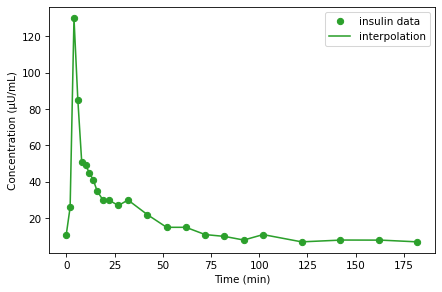

In [13]:
data.insulin.plot(style='o', color='C2', label='insulin data')
I_series.plot(color='C2', label='interpolation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (μU/mL)')

Linear interpolation connects the dots with straight lines, and for this dataset that's probably good enough. As an exercise, below, you can try out other kinds of interpolation.

## Summary

This chapter introduces a model of the interaction between glucose and insulin in the blood stream.
And it introduces a new tool, interpolation, which we'll need to implement the model.

In the next chapter, we will use measured concentrations of insulin to simulate the glucose-insulin system, and compare the results to measured concentrations of glucose.

Then you'll have a chance to implement the second part of the model, which uses measured concentrations of glucose to simulate the insulin response, and compare the results to the data.

## Exercises

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises.
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

### Exercise 1

`interpolate` is a wrapper for the SciPy function `interp1d`.
Read the documentation of `interp1d` at <http://modsimpy.com/interp>.

In particular, notice the `kind` argument, which specifies a kind of interpolation.
The default is linear interpolation, which connects the data points with straight lines.

Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation and plot the results.

In [14]:
# Solution goes here

In [ ]:
# Here's the plotting code again.

data.insulin.plot(style='o', color='C2', label='insulin data')
I_series.plot(color='C2', label='interpolation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (μU/mL)')

In [ ]:
# Solution goes here

### Exercise 2

 Interpolate the glucose data and generate a plot, similar to the previous one, that shows the data points and the interpolated curve evaluated at the time values in `t_array`.

In [15]:
# Solution goes here
G = interpolate(data.glucose)

In [17]:
# Solution goes here
G(18)
t_0 = data.index[0]
t_end = data.index[-1]
t_array = linrange(t_0, t_end)

In [18]:
G_array = G(t_array)

In [20]:
G_series = make_series(t_array, G_array)

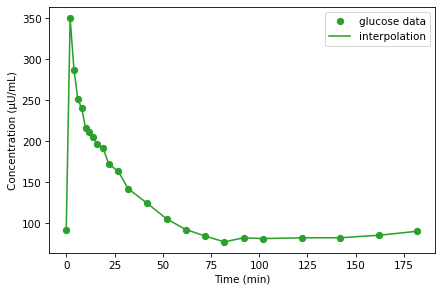

In [21]:
data.glucose.plot(style='o', color='C2', label='glucose data')
G_series.plot(color='C2', label='interpolation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (μU/mL)')